# Data Visualization

In [1]:
import shapefile
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from shapely.geometry import Polygon
from descartes.patch import PolygonPatch
from os import walk
import re


  'Matplotlib is building the font cache using fc-list. '


In [2]:
%matplotlib inline

# Geo Data

The shape data for the maps was obtained from the [Local Government Boundary Commission for Scotland](http://www.lgbc-scotland.gov.uk/maps/datafiles/index_1995_on.asp). Unfortunately, the data for each council is found in individual folders and without uniform naming conventions so we have to do some work to get everything in shape.

## Preparing the shape data
Extract the paths and the file base names from the folder names.

In [3]:
# Regex the base name of the shape files
pattern = '^.+\.shp$'

# Set the directory you want to start from
rootDir = './Councils'

shape_files = list()
for dirName, subdirList, fileList in walk(rootDir):
    for file in fileList:
        match = re.search(pattern, file)
        if match:
            shape_files.append(dirName+"/"+file[:-4])  # Unix specific

## Mapping folder names to council names

Extracting the council name from the folder name is not completely straightforward as there are two naming conventions plus a couple of gaelic names. Since this is a one-ff we'll just do the matching manually.

In [4]:
mapFolder2Council = {
    './Councils/Falkirk_Council_Area_Final_Recommendations/Falkirk_Council_Area_Final_Recommendations': "Falkirk",
    './Councils/Moray_Council_Area_Final_Recommendations/Moray_Council_Area_Final_Recommendations': "Moray",
    './Councils/Highland_Council_Area_Final_Recommendations/Highland_Council_Area_Final_Recommendations': "Highland",
    './Councils/Renfrewshire_Council_Area_Final_Recommendations/Renfrewshire_Council_Area_Final_Recommendations': "Renfrewshire",
    './Councils/Clackmannanshire_Council_Area_Final_Recommendations/Clackmannanshire_Council_Area_Final_Recommendations': "Clackmannanshire",
    './Councils/Aberdeenshire_Council_Area_Final_Recommendations/Aberdeenshire_Council_Area_Final_Recommendations': "Aberdeenshire",
    './Councils/South_Ayrshire_Council_Area_Final_recommendations/South_Ayrshire_Council_Area_Final_Recommendations': "South Ayrshire",
    './Councils/South_Lanarkshire_Council_Area_Final_Recommendations/South_Lanarkshire_Council_Area_Final_Recommendations': "South Lanarkshire",
    './Councils/NA_H_EILEANAN_AN_IAR_wards_4th/NA_H_EILEANAN_AN_IAR_wards_4th': "Na h-Eileanan Siar",
    './Councils/Midlothian_Council_Area_Final_Recommendations/Midlothian_Council_Area_Final_Recommendations': "Midlothian",
    './Councils/ARGYLL_AND_BUTE_wards_4th/ARGYLL_AND_BUTE_wards_4th': "Argyll and Bute",
    './Councils/North_Lanarkshire_Council_Area_Final_Recommendations/North_Lanarkshire_Council_Area_Final_Recommendations': "North Lanarkshire",
    './Councils/Dumfries_and_Galloway_Council_Area_Final_Recommendations/Dumfries_and_Galloway_Council_Area_Final_Recommendations': "Dumfries and Galloway",
    './Councils/WEST_LOTHIAN_wards_4th/WEST_LOTHIAN_wards_4th': "West Lothian",
    './Councils/West_Dunbartonshire_Council_Area_Final_Recommendations/West_Dunbartonshire_Council_Area_Final_Recommendations': "West Dunbartonshire",
    './Councils/ORKNEY_ISLANDS_wards_4th/ORKNEY_ISLANDS_wards_4th': "Orkney Islands",
    './Councils/Stirling_Council_Area_Final_Recommendations/Stirling_Council_Area_Final_Recommendations': "Stirling",
    './Councils/City_of_Edinburgh_Council_Area_Final_Recommendations/City_of_Edinburgh_Council_Area_Final_Recommendations': "City of Edinburgh",
    './Councils/Glasgow_City_Council_Area_Final_Recommendations/Glasgow_City_Council_Area_Final_Recommendations': "Glasgow City",
    './Councils/Angus_Council_Area_Final_Recommendations/Angus_Council_Area_Final_Recommendations': "Angus",
    './Councils/East_Dunbartonshire_Council_Area_Final_Recommendations/East_Dunbartonshire_Council_Area_Final_Recommendations': "East Dunbartonshire",
    './Councils/North_Ayrshire_Council_Area_Final_Recommendations/North_Ayrshire_Council_Area_Final_Recommendations': "North Ayrshire",
    './Councils/East_Lothian_Council_Area_Final_Recommendations/East_Lothian_Council_Area_Final_Recommendations': "East Lothian",
    './Councils/DUNDEE_CITY_wards_4th/DUNDEE_CITY_wards_4th': "Dundee City",
    './Councils/Perth_and_Kinross_Council_Area_Final_Recommendations/Perth_and_Kinross_Council_Area_Final_Recommendations': "Perth and Kinross",
    './Councils/SHETLAND_ISLANDS_wards_4th/SHETLAND_ISLANDS_wards_4th': "Shetland Islands",
    './Councils/Aberdeen_City_Council_Area_Final_Recommendations/Aberdeen_City_Council_Area_Final_Recommendations': "Aberdeen City",
    './Councils/East_Ayrshire_Council_Area_Final_Recommendations/East_Ayrshire_Council_Area_Final_Recommendations': "East Ayrshire",
    './Councils/East_Renfrewshire_Council_Area_Final_Recommendations/East_Renfrewshire_Council_Area_Final_Recommendations': "East Renfrewshire",
    './Councils/Fife_Council_Area_Final_Recommendations/Fife_Council_Area_Final_Recommendations': "Fife",
    './Councils/SCOTTISH_BORDERS_wards_4th/SCOTTISH_BORDERS_wards_4th': "Scottish Borders",
    './Councils/Inverclyde_Council_Area_Final_Recommendations/Inverclyde_Council_Area_Final_Recommendations': "Inverclyde",    
}

## Plotting the councils

and the wards. The shape data is at the ward level so when we combine with the data which is at the council level we will have a lot of spurious borders lying around. This will be most noticeable around Glagow and Edinburgh which have many wards. Fixing this would require some work to combine wards into single council shapes while respecting the fact that some wards are actually islands and can't be combined blindly wihtout introducing artifacts on the graphics. 

In [277]:
def plot_council(ax, sf, color=[0.5, 0.5, 0.5, 1.0]):
    for shape in sf.iterShapes():
        npoints=len(shape.points) # total points
        nparts = len(shape.parts) # total parts

        if nparts == 1:
            polygon = Polygon(shape.points)
            patch = PolygonPatch(polygon, facecolor=color)
            ax.add_patch(patch)

        else: # loop over parts of each shape, plot separately
            for ip in range(nparts): # loop over parts, plot separately
                i0=shape.parts[ip]
                if ip < nparts-1:
                    i1 = shape.parts[ip+1]-1
                else:
                    i1 = len(shape.points)

                polygon = Polygon(shape.points[i0:i1+1])
                patch = PolygonPatch(polygon, facecolor=color)
                ax.add_patch(patch)
    # Some bug in my libraries. If I don't do a call to plot nothing shows up??
    plt.plot([600000],[1000000])  # Trivial call to plot

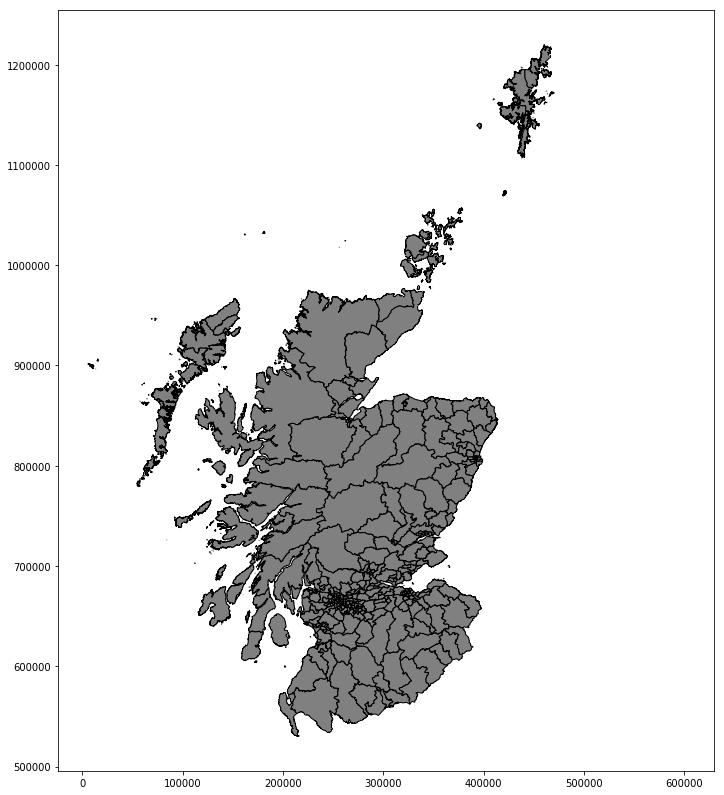

In [279]:
plt.figure(figsize=(17, 14))
ax = plt.axes()
ax.set_aspect('equal')

for council in shape_files:
    sf = shapefile.Reader(council)
    plot_council(ax, sf)

plt.show()

## Retrieving some interesting data

Lots of data are available directly from the [Scottish Government](https://statistics.gov.scot/home). A lot of it is partioned at the council level.

In [281]:
employment_data = pd.read_csv('./full_time_employment.csv')
employment_data.head()

,FeatureCode,DateCode,Measurement,Units,Value,Gender,Working Pattern
0,S12000039,2009-Q4,Count,People,2500.0,Male,Part Time
1,S12000039,2010-Q4,95% Upper Confidence Limit,Percentage Of People Employed,29.8,All,Part Time
2,S12000039,2015-Q1,95% Upper Confidence Limit,Percentage Of People Employed,32.7,All,Part Time
3,S12000039,2011-Q4,95% Upper Confidence Limit,Percentage Of People Employed,31.6,All,Part Time
4,S12000039,2008-Q1,Count,People,2000.0,Male,Part Time


## Retrieving the council names

For some reason the data downloads from [Scottish Government](https://statistics.gov.scot/home) change the council name into a `FeatureCode`. I could not find the mapping from codes to actual council names available for download so we will have to scrap it by reverse engineering the URL of the councils and parsing the HTML.

In [282]:
feature_codes = set(employment_data.FeatureCode)

In [283]:
from urllib.request import urlretrieve, urlopen
from bs4 import BeautifulSoup

atlas_url_base = "https://statistics.gov.scot/atlas/resource?uri=http%3A%2F%2Fstatistics.gov.scot%2Fid%2Fstatistical-geography%2F{}&inactive=false"

names = list()
for code in feature_codes:
    page = urlopen(atlas_url_base.format(code))
    s = str(page.read())
    page.close()
    
    name = BeautifulSoup(s, 'html.parser').find_all("h1")[1].string
    names.append(name)
    
mapFeatureCode2CouncilName = dict(zip(feature_codes, names))

In [284]:
employment_data["CouncilNames"] = employment_data.FeatureCode.map(mapFeatureCode2CouncilName)
employment_data["DateCode"] = pd.to_datetime(employment_data.DateCode)

# Hooray!!!
employment_data.head()

,FeatureCode,DateCode,Measurement,Units,Value,Gender,Working Pattern,CouncilNames
0,S12000039,2009-10-01,Count,People,2500.0,Male,Part Time,West Dunbartonshire
1,S12000039,2010-10-01,95% Upper Confidence Limit,Percentage Of People Employed,29.8,All,Part Time,West Dunbartonshire
2,S12000039,2015-01-01,95% Upper Confidence Limit,Percentage Of People Employed,32.7,All,Part Time,West Dunbartonshire
3,S12000039,2011-10-01,95% Upper Confidence Limit,Percentage Of People Employed,31.6,All,Part Time,West Dunbartonshire
4,S12000039,2008-01-01,Count,People,2000.0,Male,Part Time,West Dunbartonshire


## Mask generating function

To plot what we want we wil have to mask the data in different ways and combine many masks. Let write a function to streamline a bit this process.

In [301]:
def mask_generator(df, mask_dict, negated_masks=[]):
    """Generate masks for a dataframe from a dictionary with 
    keys being the columns and values being the filtering target.
    
    We can all also ask for some of the masks to be negated.
    """
    
    mask_list = list()
    for k in mask_dict:
        
        msk = df[k].isin(mask_dict[k])
        if k in negated_masks:
            msk = ~msk
        mask_list.append(msk)
        
    combined_mask = pd.concat(mask_list, axis=1).all(axis=1)
    return combined_mask

In [303]:
msk = mask_generator(
    employment_data,
    {
        "Gender": ["All"],
        "DateCode": ["2018-Q3"],
        "Measurement": ["Ratio"],
        "Working Pattern": ["Full Time"],
        "CouncilNames": ["Scotland"],
    },
    negated_masks=["CouncilNames"],
)

In [304]:
full_time_employment = employment_data.loc[msk]

In [307]:
# Prepare the color bar mapper
import matplotlib as mpl

min_employment = np.min(67.0)
max_employment = np.max(full_time_employment.Value.values)

cmap = mpl.cm.cool
norm = mpl.colors.Normalize(vmin=min_employment, vmax=max_employment)
mapper = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.cool)

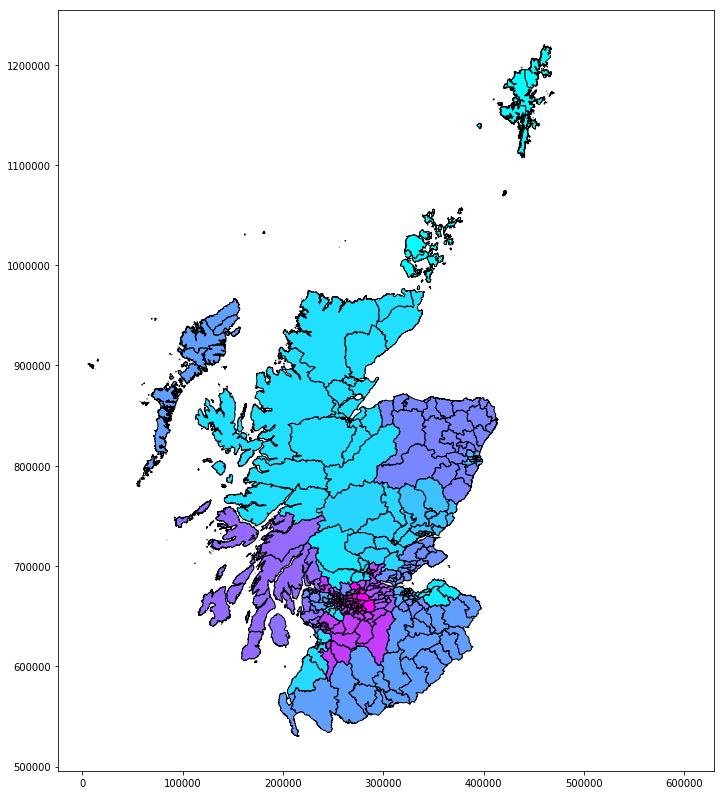

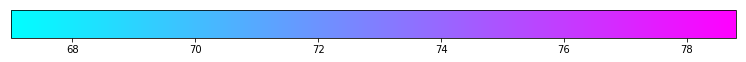

In [306]:
plt.figure(figsize=(17, 14))
ax = plt.axes() # add the axes
ax.set_aspect('equal')

for council in shape_files:
    # Select council for current set of shapes
    council_mask = full_time_employment.CouncilNames.isin([mapFolder2Council[council]])
    employment_rate = full_time_employment.loc[council_mask].Value.values[0]

    sf = shapefile.Reader(council)
    plot_council(ax, sf, mapper.to_rgba(employment_rate))

# Add a colorbar on a plot below
fig, ax = plt.subplots(figsize=(13, 1))
fig.subplots_adjust(bottom=0.5)
cb1 = mpl.colorbar.ColorbarBase(
    ax, cmap=cmap, norm=norm, orientation='horizontal')

plt.show()

We can also zoom in around Glasgow, Edinburgh, Dundee, ...

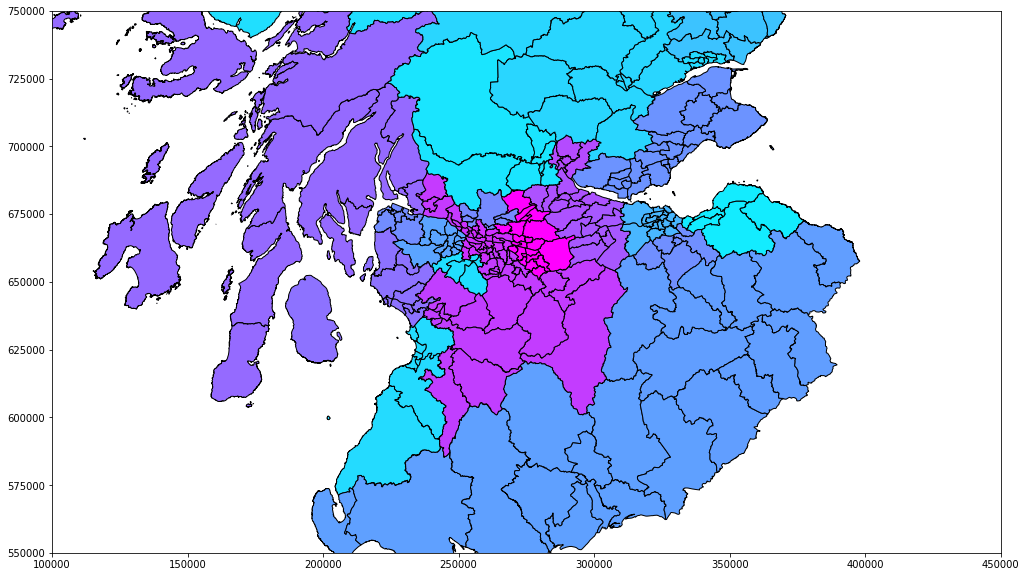

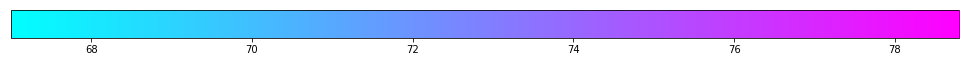

In [308]:
plt.figure(figsize=(17, 14))
ax = plt.axes() # add the axes
ax.set_aspect('equal')

for council in shape_files:
    # Select council for current set of shapes
    council_mask = full_time_employment.CouncilNames.isin([mapFolder2Council[council]])
    employment_rate = full_time_employment.loc[council_mask].Value.values[0]

    sf = shapefile.Reader(council)
    plot_council(ax, sf, mapper.to_rgba(employment_rate))

# Select central region
ax.set_xlim((100000, 450000))
ax.set_ylim((550000, 750000))    

# Add a colorbar on a plot below
fig, ax = plt.subplots(figsize=(17, 1))
fig.subplots_adjust(bottom=0.5)
cb1 = mpl.colorbar.ColorbarBase(
    ax, cmap=cmap, norm=norm, orientation='horizontal')


plt.show()

Why is the employment rate of the City Of Edinburgh council so much smaller than in Glasgow?

# Time Series
Let's check how employment rates in Scotland have evolved over time

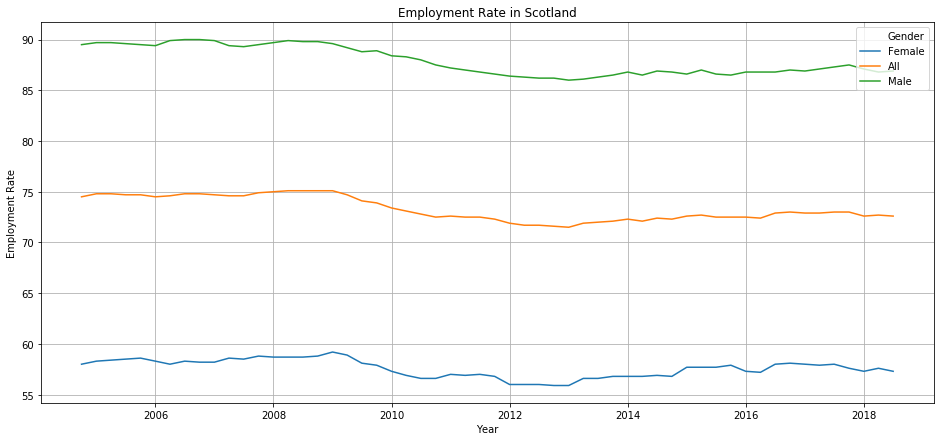

In [309]:
msk = mask_generator(
    employment_data,
    {
        "Measurement": ["Ratio"],
        "Working Pattern": ["Full Time"],
        "CouncilNames": ["Scotland"],
    },
)
employment_time_series_df = employment_data.loc[msk].sort_values("DateCode")

fig = plt.figure(figsize=(16, 7))
g = sns.lineplot(x="DateCode", y="Value", hue="Gender", data=employment_time_series_df)
plt.xlabel("Year")
plt.ylabel("Employment Rate")
plt.title("Employment Rate in Scotland")
plt.grid()
plt.show()

Two thinks are clear:
- The 2007-2008 financial crisis with a big dip in employment.
- The presence of consistent and big differences between male and female employment.

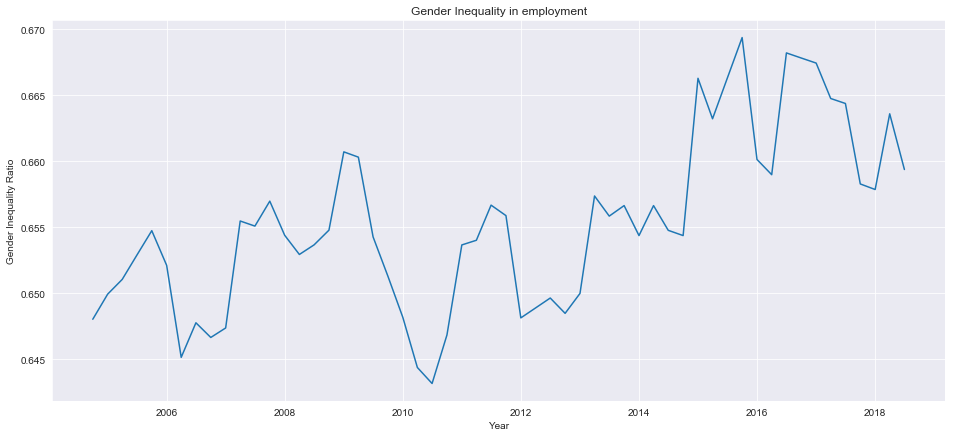

In [384]:
msk = mask_generator(
    employment_data,
    {
        "Measurement": ["Ratio"],
        "Working Pattern": ["Full Time"],
        "CouncilNames": ["Scotland"],
    },
)
employment_time_series_df = employment_data.loc[msk].sort_values("DateCode")

man_msk = mask_generator(employment_time_series_df, {"Gender":["Male"]})
woman_msk = mask_generator(employment_time_series_df, {"Gender":["Female"]})


fig = plt.figure(figsize=(16, 7))
g = sns.lineplot(
    x=employment_time_series_df.loc[woman_msk].DateCode.values,
    y=employment_time_series_df.loc[woman_msk].Value.values / employment_time_series_df.loc[man_msk].Value.values,
)
plt.xlabel("Year")
plt.ylabel("Gender Inequality Ratio")
plt.title("Gender Inequality in employment")
# plt.grid()
plt.show()

Workforce gender inbalance is still an issue.

The impact of the financial crisis becomes much more obvious if we only plot gender aggregated data.

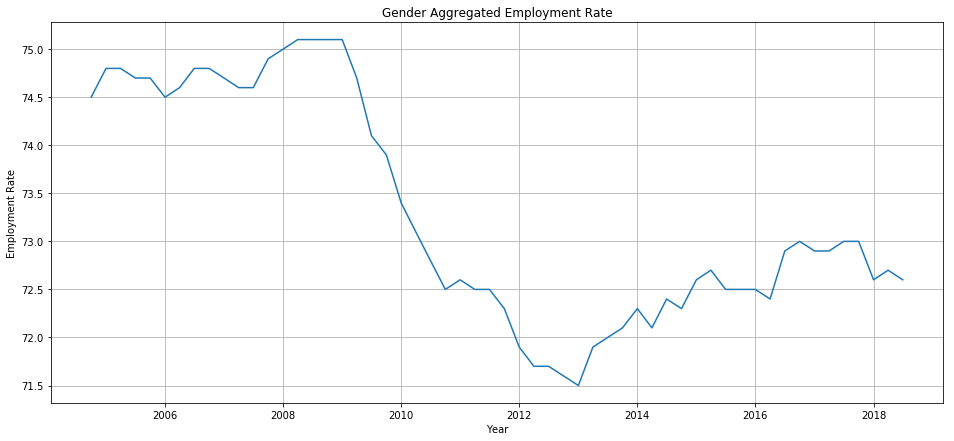

In [313]:
msk = mask_generator(
    employment_data,
    {
        "Gender": ["All"],
        "Measurement": ["Ratio"],
        "Working Pattern": ["Full Time"],
        "CouncilNames": ["Scotland"],
    },
)
employment_time_series_df = employment_data.loc[msk].sort_values("DateCode")


fig = plt.figure(figsize=(16, 7))
g = sns.lineplot(x="DateCode", y="Value", data=employment_time_series_df)
plt.xlabel("Year")
plt.ylabel("Employment Rate")
plt.title("Gender Aggregated Employment Rate")
plt.grid()
plt.show()

# Clouds of Words

Clouds of words allows a more visual representation of the main ideas in a set of documents. Below we take data from a car newsgroups to see what the algorithm can come up with.

In [231]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.manifold import TSNE

newsgroups_train = fetch_20newsgroups(
    subset='train',
    remove=('headers', 'footers', 'quotes'),
    categories=['rec.autos'],
)["data"]

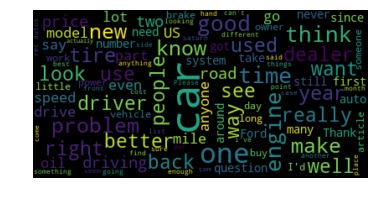

In [246]:
from wordcloud import WordCloud

from nltk.corpus import stopwords
stop_words = stopwords.words('english')

# We add some extra stop words to make the final picture nicer
wc = WordCloud(
    max_words=100,
    stopwords=stop_words + ['would', 'thing', 'could', 'like', 'much', 'I\'m', 'may', 'also', 'get'],
    max_font_size=50)
im = wc.generate(' '.join(newsgroups_train),)

plt.imshow(im, interpolation='bilinear')
plt.axis("off")
plt.show()

# Network graphs

This could be useful for visualizing relationships in between networks of companies. With this we could study what would be the effect of removing a company and predict cascades of failures.

Lots of network data can be obtained from [Stanford University](http://snap.stanford.edu/data/#socnets). The dataset below is for Facebook connections.

The plots could be prettier by programs specific for networks like [Gephi](https://gephi.org)

In [318]:
import networkx as nx

G=nx.Graph()
facebook_edges = np.loadtxt('./facebook_combined.txt', dtype='int')

In [319]:
G.add_edges_from(facebook_edges)

/usr/local/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:565: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


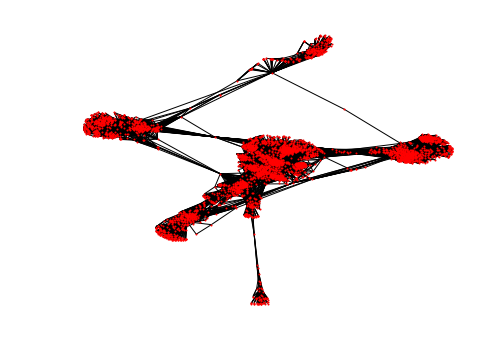

In [325]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6));
nx.draw(G, node_size=1, ax=ax)

This social graph shows several well defined subnetworks. This is maybe similar to a network of provider/supplier edges between businesses. They would be likely grouped into clusters that depend on the specific industry with some major companies connected to almost all of them, for example courier and delivery services (e.g. Royal Mail) or mega corps (e.g. Google). 

# Regression plots

This are really useful to identify problems when developing regression problems.

In [391]:
sigma = 0.1
n_samples = 400

true_values = np.random.rand(n_samples)
predicted_values = true_values + sigma*np.random.randn(len(true_values)) + 0.2*true_values**2
residuals = true_values - predicted_values

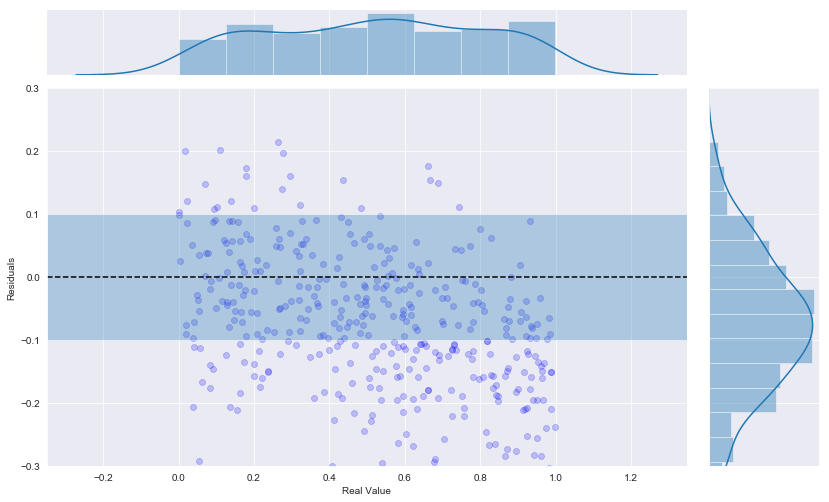

In [392]:
sns.set_style("darkgrid")

g = sns.JointGrid(true_values, residuals)
g.plot_joint(plt.scatter, color='b', alpha=0.2)
g.plot_marginals(sns.distplot, )

g.ax_joint.axhline(0, color='k', linestyle='--')

g.ax_joint.axhspan(-abs(sigma), abs(sigma), alpha=0.3)

g.fig.set_figwidth(12)
g.fig.set_figheight(7)
g.set_axis_labels("Real Value", "Residuals")

plt.ylim((-0.3, 0.3))
plt.show()

# Correlation Matrices

Great to check if your features/target are (linearly) related to each other. Can also provide some first approximation as to what features we want to retain for use in the predictive models.

In [367]:
from sklearn.datasets import california_housing

california_download = california_housing.fetch_california_housing()
cali_df = pd.DataFrame(california_download["data"], columns=california_download["feature_names"])
cali_df["HouseValue"] = california_download["target"]

In [369]:
print(california_download["DESCR"])

California housing dataset.

The original database is available from StatLib

    http://lib.stat.cmu.edu/datasets/

The data contains 20,640 observations on 9 variables.

This dataset contains the average house value as target variable
and the following input variables (features): average income,
housing average age, average rooms, average bedrooms, population,
average occupation, latitude, and longitude in that order.

References
----------

Pace, R. Kelley and Ronald Barry, Sparse Spatial Autoregressions,
Statistics and Probability Letters, 33 (1997) 291-297.




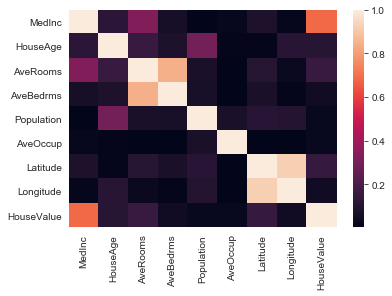

In [370]:
import seaborn as sns
corr = cali_df.corr()
sns.heatmap(
    abs(corr), 
    xticklabels=corr.columns.values,
    yticklabels=corr.columns.values,
)

The most obvious feature to note here is the very high correlation between house value and average incomes. Something interesting here is also that number of rooms is not very strongly (linearly) correlated with house value. We'll have a quick look at that below.

We can also see how people with higher incomes (MedInc) tend to buy houses with more rooms. We can also make the rather obvious observation that houses with more rooms tend to have more bedrooms.

Fun fact! Latitude matters because california is narrow, long and runs north to south. So it is a good indicator of its position.

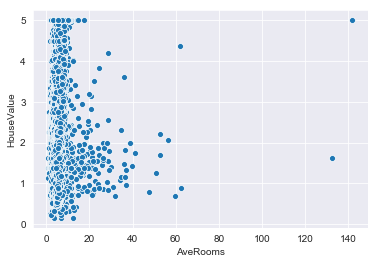

In [372]:
sns.scatterplot(x="AveRooms", y="HouseValue", data=cali_df)

Ugggg, we got some houses with massive amounts of rooms. This can have a big impact on the estimates for the correlation above. Let's just plot houses with a sensible number of rooms, 10 and less. I suppose that here we have data for all kinds of houses (i.e. farm houses, McMansions, city flats, etc).

There are plenty of interesting things to find in this data set with some more work.

(0.5, 10)

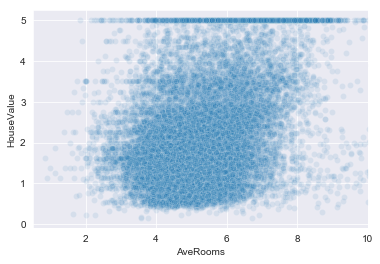

In [376]:
sns.scatterplot(x="AveRooms", y="HouseValue", data=cali_df, alpha=0.1)
plt.xlim([0.5, 10])

Lets do now the correlation matrix with this houses. We will also remove those with values of 5.

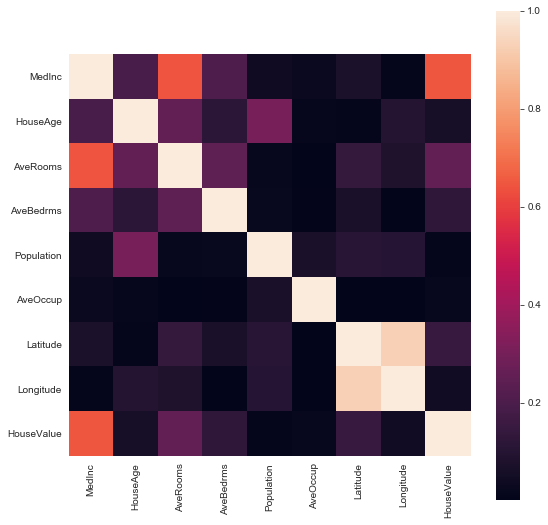

In [382]:
msk_rooms = cali_df["AveRooms"] < 10
msk_value = cali_df["HouseValue"] < 4.9

# Combine all the masks
msk = pd.concat((
    msk_rooms,
    msk_value,
), axis=1).all(axis=1)

corr = cali_df.loc[msk].corr()


plt.figure(figsize=(9, 9))
ax = plt.axes() # add the axes
ax.set_aspect('equal')

sns.heatmap(
    abs(corr), 
    xticklabels=corr.columns.values,
    yticklabels=corr.columns.values,
)

# Confusion Matrices

Lets run a very simple classifier on the Iris dataset just to show what a confusion matrix looks like.

In [395]:
from sklearn.datasets import load_iris
from pandas.plotting import scatter_matrix

In [397]:
iris = load_iris()
iris_df = pd.DataFrame(iris['data'], columns=iris['feature_names'])
iris_df['target'] = iris['target']

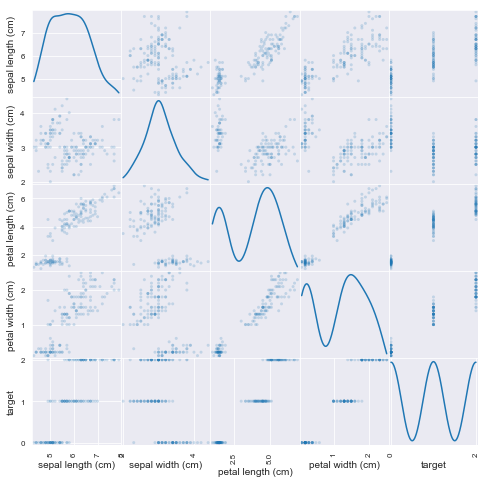

In [399]:
scatter_matrix(iris_df, alpha=0.2, figsize=(8, 8), diagonal='kde')
plt.show()

In [402]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(iris["data"], iris["target"], test_size=0.4)

In [405]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

pipeline = Pipeline(
    [
        ('scaler', StandardScaler()),
        ('clf', LogisticRegression(solver='lbfgs')),
    ]
)
pipeline.steps

[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)),
 ('clf',
  LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
            intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
            penalty='l2', random_state=None, solver='lbfgs', tol=0.0001,
            verbose=0, warm_start=False))]

In [408]:
pipeline.fit(X_train, y_train)
pipeline.score(X_test, y_test)
y_pred = pipeline.predict(X_test)

Normalized confusion matrix
[[0.95 0.05 0.  ]
 [0.   0.88 0.12]
 [0.   0.04 0.96]]


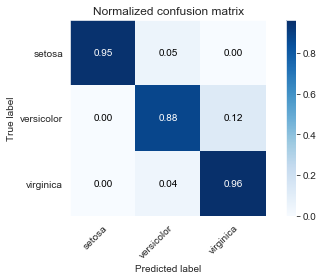

In [413]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels


# From -> https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

# # Plot non-normalized confusion matrix
# plot_confusion_matrix(y_test, y_pred, classes=class_names,
#                       title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=iris["target_names"], normalize=True,
                      title='Normalized confusion matrix')

plt.grid(0)
plt.show()

# Other plots

There are lots and lots of other viz techniques out there:
- Scatter plot
- Heat maps
- Line plots
- Pie charts
- Histograms
- Custom charts